In [1]:
%cd ..

import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

pd.set_option('display.max_columns', None)

/run/media/nazif/2F946E411BA61D49/thesis


In [2]:
def scale_columns(df, cols):

    # Create a scaler object
    scaler = StandardScaler()

    # Scale the specified columns in the dataframe
    df_scaled = df.copy()
    df_scaled[cols] = scaler.fit_transform(df[cols])

    return df_scaled


def report_performance(model, X, y):
    # Make predictions on the input data
    y_pred = model.predict(X)

    # Calculate performance metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc,
    }


def get_feature_importances(model):
    """
    Get feature importances of every column from a model.

    Args:
        model: The trained model.

    Returns:
        dict: A dictionary containing the feature importances for each column, with column names as keys.
    """
    feature_importances = {}

    # Check if the model has the attribute "feature_importances_"
    if hasattr(model, "feature_importances_"):
        # Get the feature importances
        importances = model.feature_importances_

        # Get the column names
        if hasattr(model, "get_booster"):
            column_names = model.get_booster().feature_names
        elif hasattr(model, "named_steps"):
            column_names = model.named_steps["preprocessor"].get_feature_names_out(
            )
        else:
            column_names = []

        # Store the feature importances with their respective column names
        for feature_name, importance in zip(column_names, importances):
            feature_importances[feature_name] = importance

        # Sort the feature importances in descending order
        feature_importances = dict(
            sorted(feature_importances.items(), key=lambda x: x[1], reverse=True))

    return feature_importances


def compare_importances(model1_importances, model2_importances):
    # Convert dictionaries to DataFrames
    df1 = pd.DataFrame(model1_importances.items(),
                       columns=['Feature', 'Model 1'])
    df2 = pd.DataFrame(model2_importances.items(),
                       columns=['Feature', 'Model 2'])

    # Merge the DataFrames on the 'Feature' column
    merged_df = pd.merge(df1, df2, on='Feature', how='outer')

    # Calculate change and add indicators
    merged_df['Change'] = merged_df.apply(
        lambda row: '+' if row['Model 2'] > row['Model 1'] else ('-' if row['Model 2'] < row['Model 1'] else ''), axis=1)
    merged_df['Importance Change'] = merged_df['Model 2'] - \
        merged_df['Model 1']

    # Sort by Importance Change descending
    merged_df = merged_df.sort_values(by='Importance Change', ascending=False)

    return merged_df.style.apply(
        lambda row: [
            'color:black; background-color: #98ff98'
            if val == '+'
            else (
                'color:black; background-color: #8B0000' if val == '-' else ''
            )
            for val in row
        ],
        axis=1,
    )


def compare_metrics(model1_metrics, model2_metrics):
    # Convert dictionaries to DataFrames
    df1 = pd.DataFrame(model1_metrics.items(), columns=['Metric', 'Model 1'])
    df2 = pd.DataFrame(model2_metrics.items(), columns=['Metric', 'Model 2'])

    # Merge the DataFrames on the 'Metric' column
    merged_df = pd.merge(df1, df2, on='Metric', how='outer')

    # Calculate change and add indicators
    merged_df['Change'] = merged_df.apply(
        lambda row: '+' if row['Model 2'] > row['Model 1'] else ('-' if row['Model 2'] < row['Model 1'] else ''), axis=1)
    merged_df['Change In Value'] = merged_df['Model 2'] - merged_df['Model 1']

    return merged_df.style.apply(
        lambda row: [
            'color:black; background-color: #98ff98'
            if val == '+'
            else (
                'color:black; background-color: #8B0000' if val == '-' else ''
            )
            for val in row
        ],
        axis=1,
    )


def drop_column_and_score(X, y):
    # List of metrics to calculate
    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1 Score': f1_score
    }

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)

    # Train an initial XGBoost model
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    initial_scores = calculate_metrics(metrics, y_test, model.predict(X_test))
    scores = {'Initial Model': initial_scores}
    # Drop each column one by one and train a new model
    for column in X.columns:
        # Create a new X without the current column
        X_dropped = X.drop(column, axis=1)

        # Split the modified data into train and test sets
        X_train_dropped, X_test_dropped, y_train, y_test = train_test_split(
            X_dropped, y, test_size=0.2, random_state=42, stratify=y)

        # Train a new XGBoost model without the current column
        model_dropped = xgb.XGBClassifier()
        model_dropped.fit(X_train_dropped, y_train)

        # Calculate the scores of the new model
        column_scores = calculate_metrics(
            metrics, y_test, model_dropped.predict(X_test_dropped))
        scores[f'Dropped {column}'] = column_scores

    return pd.DataFrame(scores).T


def calculate_metrics(metrics, y_true, y_pred):
    scores = {}
    for metric_name, metric_func in metrics.items():
        score = metric_func(y_true, y_pred)
        scores[metric_name] = score
    return scores


def stylizer(df):
    def apply_color(row):
        color = []
        for i, cell in enumerate(row):
            if cell == df.iloc[0, i]:
                color.append('background-color: black')
            else:
                if cell > df.iloc[0, i]:
                    color.append('background-color: green')
                else:
                    color.append('background-color: red')
        return color

    return df.style.apply(apply_color, axis=1)



def find_most_correlated_features(data, threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = data.corr().abs()

    # Extract the upper triangle of the correlation matrix
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    # Find feature pairs with correlation above the threshold
    correlated_pairs = upper_triangle.unstack().sort_values(ascending=False)
    correlated_pairs = correlated_pairs[correlated_pairs > threshold]

    return correlated_pairs


def get_average_correlations(df: pd.DataFrame) -> pd.Series:
    return df.corr().abs().mean()


In [3]:
df = pd.read_csv("results/5_features.csv")


In [4]:
cols_to_keep = [
    "pred_energy",
    "pred_num_basepairs",
    "pred_seed_basepairs",
    "ta_log10",
    "sps_mean",
    "anchor_a",
    "6mer_seed",
    "match_8",
    "6mer_seed_1_mismatch",
    "compensatory_site",
    "supplementary_site",
    "supplementary_site_2",
    "empty_seed",
    "9_consecutive_match_anywhere",
    "mirna_conservation",
    "midpoint",
    "close_proximity",
    "seed_8mer",
    "seed_7mer_a1",
    "seed_7mer_m8",
    "seed_compensatory",
    "seed_clash_2",
    "seed_clash_3",
    "seed_clash_4",
    "seed_clash_5",
    "mre_au_content",
    "local_au_content",
    "label"
]

df = df[cols_to_keep]

In [5]:
df.head()

,pred_energy,pred_num_basepairs,pred_seed_basepairs,ta_log10,sps_mean,anchor_a,6mer_seed,match_8,6mer_seed_1_mismatch,compensatory_site,supplementary_site,supplementary_site_2,empty_seed,9_consecutive_match_anywhere,mirna_conservation,midpoint,close_proximity,seed_8mer,seed_7mer_a1,seed_7mer_m8,seed_compensatory,seed_clash_2,seed_clash_3,seed_clash_4,seed_clash_5,label
0,-27.7,20,6,3.393,-8.18,0,1,1,0,1,1,0,0,1,2.0,26,0,0,0,0,0,1,0,0,0,1
1,-26.2,17,6,3.393,-8.18,0,1,1,0,1,1,0,0,1,2.0,15,0,0,0,0,0,1,0,0,0,1
2,-23.6,19,6,3.393,-8.18,0,1,0,0,1,1,1,0,1,2.0,7,0,0,0,0,0,0,0,0,0,1
3,-23.8,19,6,3.393,-8.18,0,1,0,0,1,1,1,0,1,2.0,7,0,0,0,0,0,0,0,0,0,1
4,-24.0,18,6,3.393,-8.18,0,1,1,0,0,0,0,0,1,2.0,6,0,0,0,1,0,0,0,0,0,1


In [6]:
# scaling columns
cols_to_scale = ["pred_energy", "ta_log10", "sps_mean"]
df = scale_columns(df, cols_to_scale)

# scale midpoint using minmax
minmax = MinMaxScaler(feature_range=(0, 1))
df["midpoint"] = minmax.fit_transform(df["midpoint"].values.reshape(-1, 1))


df.head()

,pred_energy,pred_num_basepairs,pred_seed_basepairs,ta_log10,sps_mean,anchor_a,6mer_seed,match_8,6mer_seed_1_mismatch,compensatory_site,supplementary_site,supplementary_site_2,empty_seed,9_consecutive_match_anywhere,mirna_conservation,midpoint,close_proximity,seed_8mer,seed_7mer_a1,seed_7mer_m8,seed_compensatory,seed_clash_2,seed_clash_3,seed_clash_4,seed_clash_5,label
0,-1.783590,20,6,-0.346856,-0.097852,0,1,1,0,1,1,0,0,1,2.0,0.301370,0,0,0,0,0,1,0,0,0,1
1,-1.599038,17,6,-0.346856,-0.097852,0,1,1,0,1,1,0,0,1,2.0,0.150685,0,0,0,0,0,1,0,0,0,1
2,-1.279149,19,6,-0.346856,-0.097852,0,1,0,0,1,1,1,0,1,2.0,0.041096,0,0,0,0,0,0,0,0,0,1
3,-1.303756,19,6,-0.346856,-0.097852,0,1,0,0,1,1,1,0,1,2.0,0.041096,0,0,0,0,0,0,0,0,0,1
4,-1.328363,18,6,-0.346856,-0.097852,0,1,1,0,0,0,0,0,1,2.0,0.027397,0,0,0,1,0,0,0,0,0,1


In [7]:
# Train test split
X = df.drop("label", axis=1)
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
report = report_performance(model, X_test, y_test)
importances = get_feature_importances(model)

In [9]:
report

{'Accuracy': 0.9875937286980232,
 'Precision': 0.9878754477817581,
 'Recall': 0.9870594713656388,
 'F1-Score': 0.9874672910067483,
 'ROC AUC': 0.9875886068683447}

In [17]:
importances

{'pred_energy': 0.53917366,
 'mirna_conservation': 0.112520434,
 'midpoint': 0.068397924,
 'empty_seed': 0.05594298,
 'ta_log10': 0.034584872,
 'pred_num_basepairs': 0.02910997,
 'sps_mean': 0.026775558,
 'mre_au_content': 0.02012221,
 'pred_seed_basepairs': 0.012895588,
 '9_consecutive_match_anywhere': 0.012025117,
 'seed_7mer_m8': 0.01087321,
 'close_proximity': 0.009052075,
 'seed_7mer_a1': 0.0072835144,
 'supplementary_site_2': 0.0072361557,
 'supplementary_site': 0.0066045583,
 'local_au_content': 0.006065501,
 'match_8': 0.0060393945,
 'compensatory_site': 0.0060237404,
 'seed_compensatory': 0.005556926,
 'seed_clash_2': 0.004721801,
 'anchor_a': 0.0043293103,
 'seed_clash_5': 0.0041563166,
 'seed_8mer': 0.003971668,
 'seed_clash_4': 0.00352268,
 '6mer_seed_1_mismatch': 0.0030147466,
 '6mer_seed': 0.0,
 'seed_clash_3': 0.0}

In [18]:
col_drop_results = drop_column_and_score(X, y)


In [19]:
stylized_df = stylizer(col_drop_results)
stylized_df.set_caption("Model")
stylized_df

,Accuracy,Precision,Recall,F1 Score
Initial Model,0.988003,0.989232,0.986509,0.987869
Dropped pred_energy,0.979141,0.983329,0.974394,0.978841
Dropped pred_num_basepairs,0.986094,0.988108,0.983756,0.985927
Dropped pred_seed_basepairs,0.987866,0.989229,0.986233,0.987729
Dropped ta_log10,0.986639,0.988391,0.984581,0.986483
Dropped sps_mean,0.986639,0.988932,0.984031,0.986475
Dropped anchor_a,0.987048,0.988131,0.985683,0.986906
Dropped 6mer_seed,0.988003,0.989232,0.986509,0.987869
Dropped match_8,0.988684,0.990058,0.987059,0.988556
Dropped 6mer_seed_1_mismatch,0.988684,0.989517,0.987610,0.988563


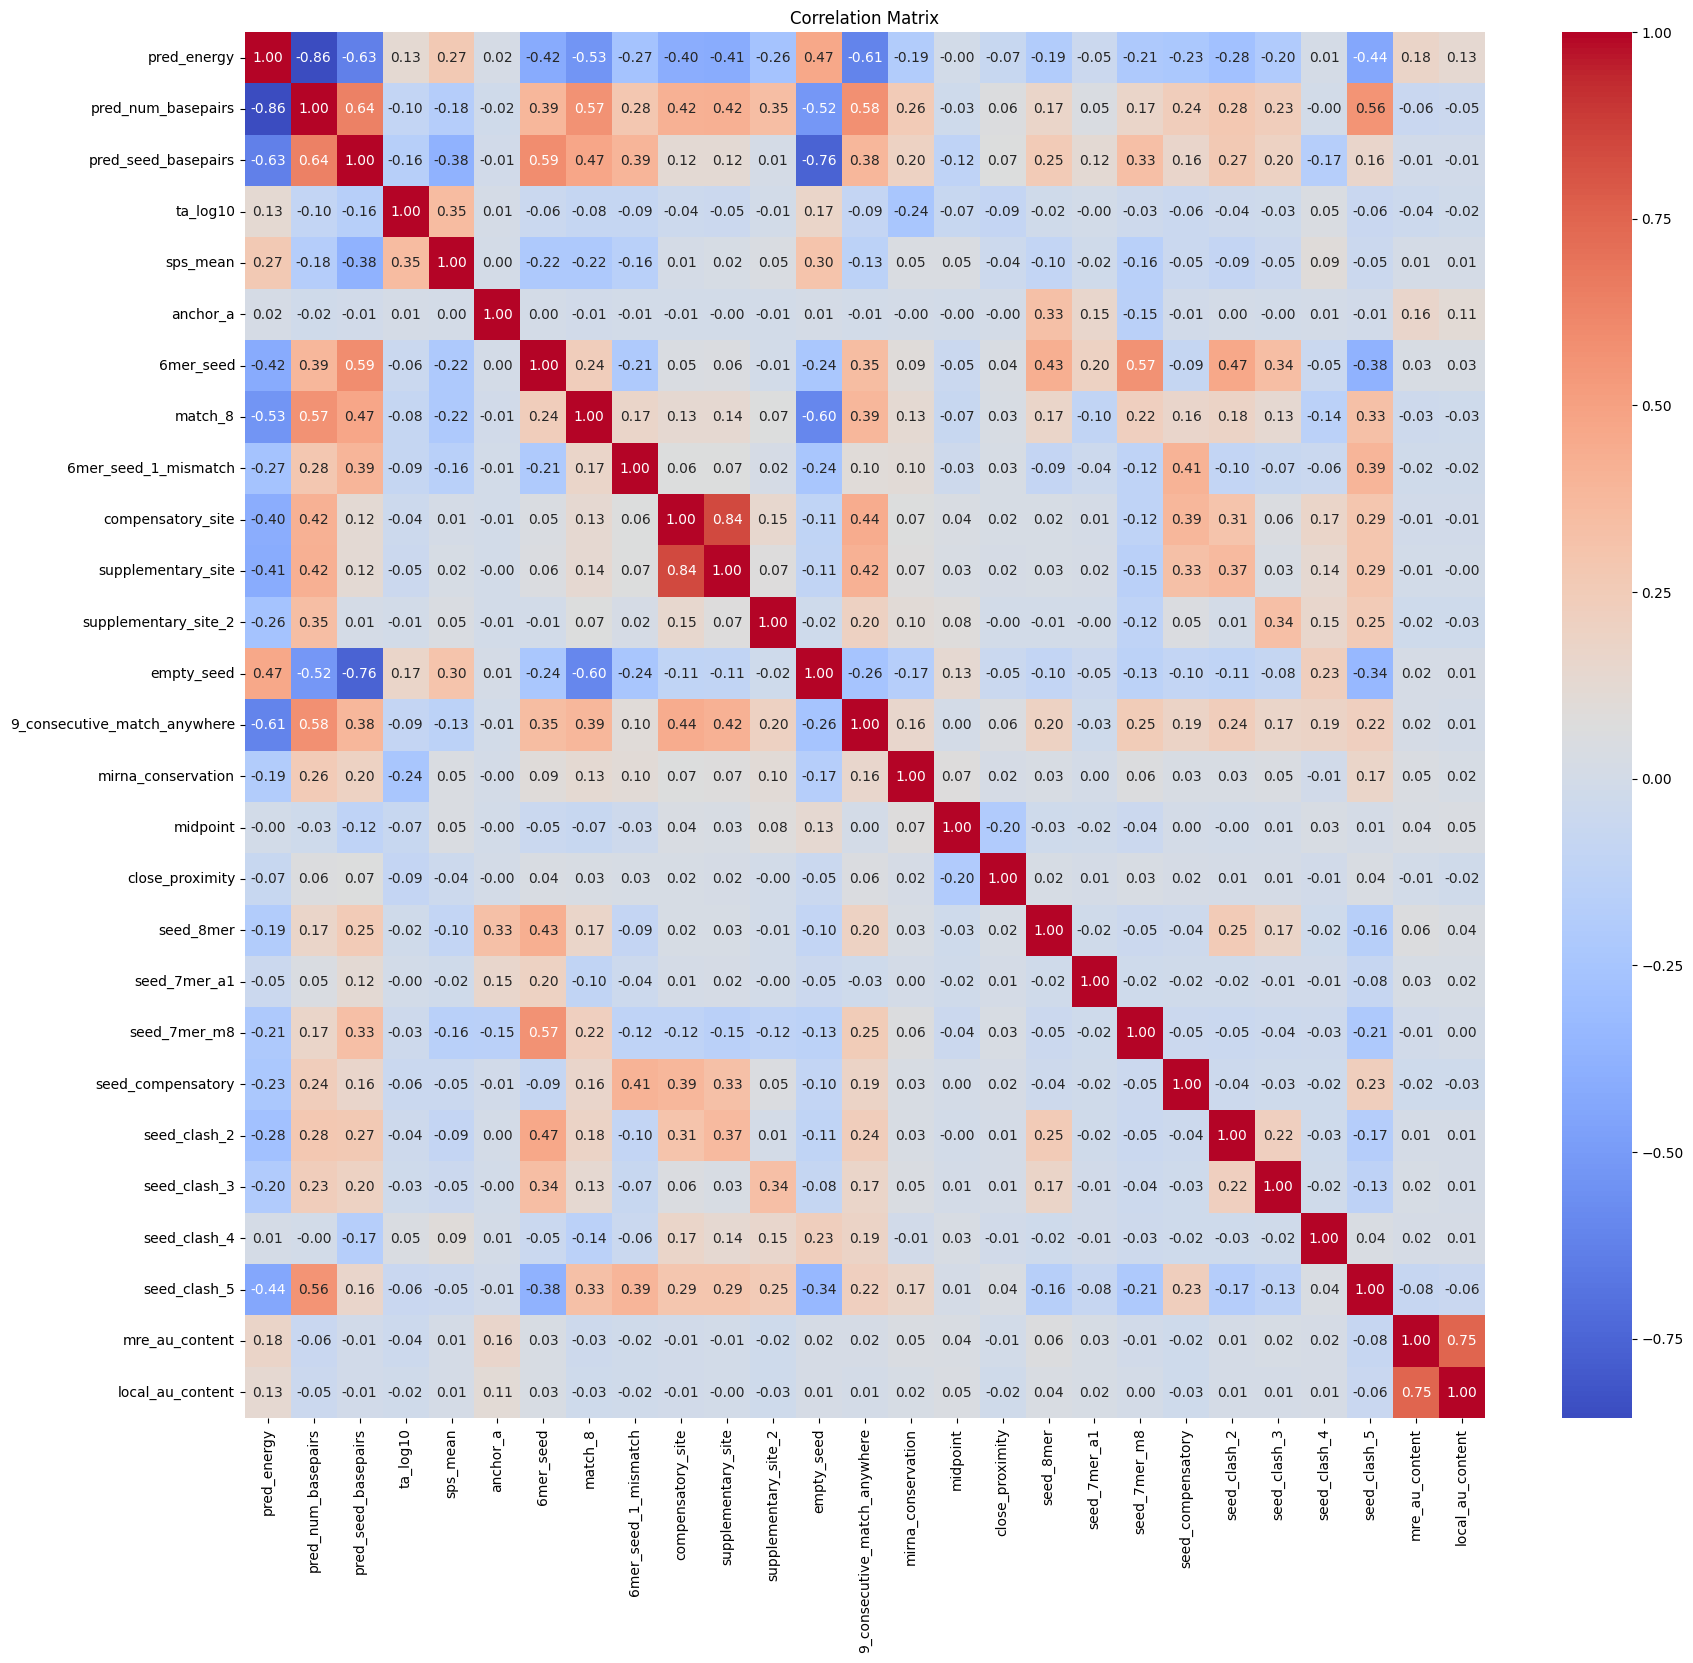

In [20]:
# Assuming your features are stored in a DataFrame called 'data'
correlation_matrix = X.corr()


import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [21]:
import pandas as pd
import numpy as np



find_most_correlated_features(X)

pred_num_basepairs  pred_energy            0.856481
supplementary_site  compensatory_site      0.842587
empty_seed          pred_seed_basepairs    0.755561
local_au_content    mre_au_content         0.746862
dtype: float64

In [ ]:
importances

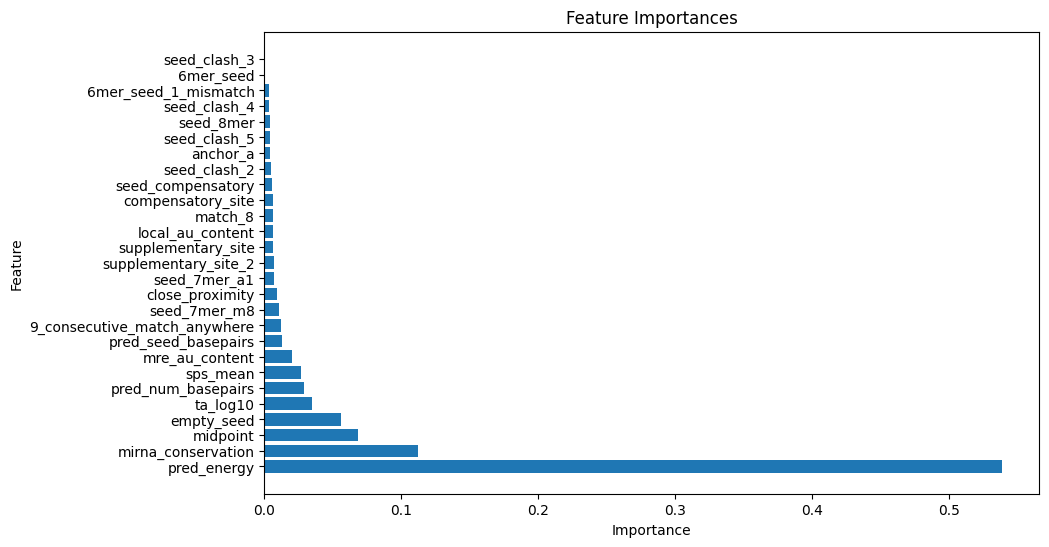

In [26]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(list(importances.keys()), list(importances.values()))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


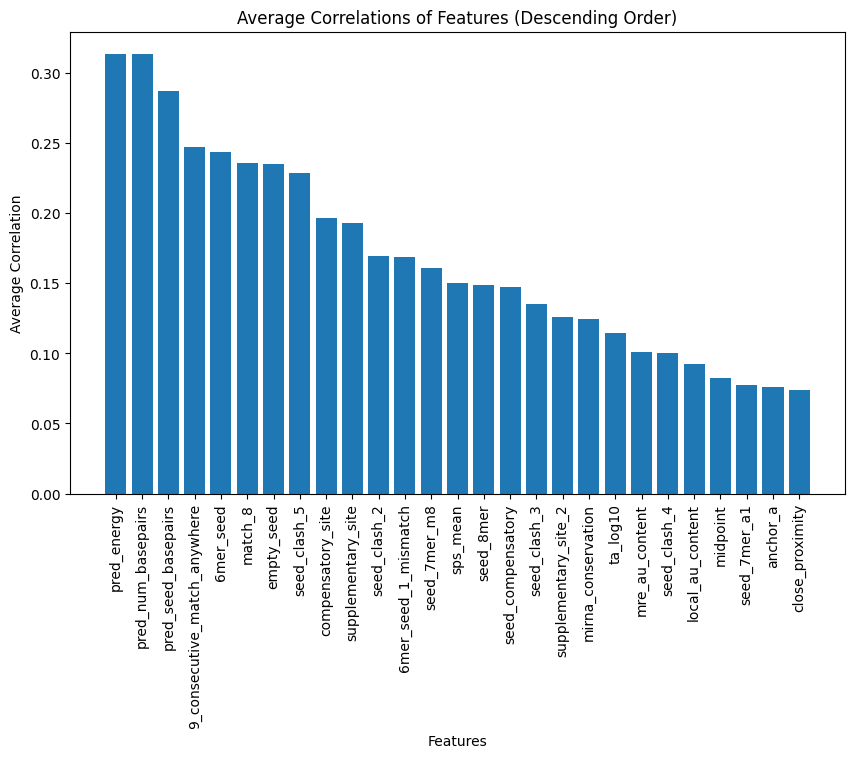

In [27]:

avgcorr = get_average_correlations(X)

avgcorr = avgcorr.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(avgcorr.index, avgcorr.values)
plt.xlabel('Features')
plt.ylabel('Average Correlation')
plt.title('Average Correlations of Features (Descending Order)')
plt.xticks(rotation=90)
plt.show()

In [28]:
param_grid = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.1, 0.5],
    "n_estimators": [100, 500, 1000]
}

grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
print("Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}
Accuracy: 98.75%


In [29]:
model_after_cv = xgb.XGBClassifier(**grid_search.best_params_)

model_after_cv.fit(X_train, y_train)
score_after_cv = model_after_cv.score(X_test, y_test)
print(f"accuracy after cv: {score_after_cv}")

accuracy after cv: 0.9869120654396728


In [30]:
percentage_increase = (model_after_cv.score(X_test, y_test) - model.score(X_test, y_test)) / model.score(X_test, y_test) * 100

print(f"The accuracy increased by {percentage_increase:.2f}% after CV")


The accuracy increased by -0.11% after CV


In [10]:

# Save the trained model
model.save_model('results/model.xgb')
